In [12]:
import os
import ast
import sys
import time
import yaml
from tqdm import trange

from pymongo import MongoClient
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns



import pandas as pd
import numpy as np
from dotenv import load_dotenv
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Import libraries for working with language models and Google Gemini
from langchain_core.prompts import PromptTemplate
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate

chat_model = "llama3-8b-8192"
load_dotenv()
groq_api_key = os.getenv('GROQ_API_KEY')
GEMINI_KEY = os.environ.get('GEMINI_KEY')
genai.configure(api_key=GEMINI_KEY)


# Normally where to do this? (in which function?)
with open("../gradio_config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Initialise mongo client.
mongo_client = MongoClient(config["database"]["uri"])

In [13]:
def load_mongodb():
    # Connect to the MongoDB client
    try:
        db = mongo_client[config["database"]["name"]]
        train_documents = db[config["database"]["train_collection"]].find()
        print("Train data successfully fetched from MongoDB\n")
    except Exception as error: 
        print(f"Unable to fetch train data from MongoDB. Check your connection the database...\nERROR: {error}\n")
        sys.exit()   
    try:
        test_docs = db[config["database"]["test_collection"]].find()
        print("Test data successfully fetched from MongoDB\n")
    except:
        print(f"Unable to fetch test data from MongoDB. Check your connection the database...\nERROR: {error}\n")
        sys.exit()
    df_train = pd.DataFrame.from_dict(list(train_documents))
    df_test = pd.DataFrame.from_dict(list(test_docs))
    df = pd.concat([df_train, df_test], axis=0)
    return df

df= load_mongodb()

Train data successfully fetched from MongoDB

Test data successfully fetched from MongoDB



In [14]:
def scale_body_embeddings(df):
    print("Processing embedding data and scaling data...\n")
    #Deserializing the embeddings
    body_embeddings = np.array(df['embeddings'].apply(ast.literal_eval).tolist())
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(body_embeddings)
    return embeddings

def scale_title_embeddings(df):
    print("Processing embedding data and scaling data...\n")
    #Deserializing the embeddings
    title_embeddings = np.array(df['Title_embeddings'].apply(ast.literal_eval).tolist())
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(title_embeddings)
    return embeddings

def scale_body_text_embeddings(df):
    title_embeddings = np.array(df['Title_embeddings'].apply(ast.literal_eval).tolist())
    body_embeddings = np.array(df['embeddings'].apply(ast.literal_eval).tolist())

    title_weight = 0.7
    body_weight = 0.3
    combined_embeddings = title_weight * title_embeddings + body_weight * body_embeddings
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(combined_embeddings)
    return embeddings

def get_variance_performance_with_pca(train_embeddings):
# Experiment for this variance range of 92% to 95%
    print("Finding best Model parameters...\n")
    variance = 0.95

    pca = PCA(n_components=variance)
    print(f"Dimensions before PCA: {train_embeddings.shape}\n")
    train_pca_embeddings = pca.fit_transform(train_embeddings)
    print(f"Dimensions after PCA: {train_pca_embeddings.shape}\n")
        
    # Range of max_d values to try, for this dataset we use 65
    max_d = 0.6
        
    # List to store silhouette scores
    silhouette_scores_train = []

    # Perform hierarchical clustering
    Z = linkage(train_pca_embeddings, method='average', metric='cosine')

    clusters_train = fcluster(Z, max_d, criterion='distance')
            
    # Calculate silhouette score only if there are at least 2 unique clusters and fewer than the number of samples
    if 1 < len(set(clusters_train)) < len(train_pca_embeddings):
        score_train = silhouette_score(train_pca_embeddings, clusters_train)
    else:
        score_train = -1  # Assign a score of -1 if less than 2 unique clusters or too many clusters
            
    silhouette_scores_train.append(score_train)

    # Plot the dendrogram
    plt.figure(figsize=(200, 15))
    plt.title(f'Dendrogram for Variance: {variance} (Body Embeddings with PCA)')
    dendrogram(Z)
    plt.axhline(y=max_d, color='r', linestyle='--')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.savefig(f'../clustering/dendrogram_variance_{variance}.png')
    
def get_variance_performance_without_pca(train_embeddings):
    # Experiment for this variance range of 92% to 95%
    print("Finding best Model parameters...\n")
    variance = 0.95

    print(f"Dimensions before PCA: {train_embeddings.shape}\n")
        
    # Range of max_d values to try, for this dataset we use 65
    max_d = 0.6
        
    # List to store silhouette scores
    silhouette_scores_train = []

    # Perform hierarchical clustering
    Z = linkage(train_embeddings, method='average', metric='cosine')

    clusters_train = fcluster(Z, max_d, criterion='distance')
            
    # Calculate silhouette score only if there are at least 2 unique clusters and fewer than the number of samples
    if 1 < len(set(clusters_train)) < len(train_embeddings):
        score_train = silhouette_score(train_embeddings, clusters_train)
    else:
        score_train = -1  # Assign a score of -1 if less than 2 unique clusters or too many clusters
            
    silhouette_scores_train.append(score_train)

    # Plot the dendrogram
    plt.figure(figsize=(200, 15))
    plt.title(f'Dendrogram for Variance: {variance} (Body Embeddings with PCA)')
    dendrogram(Z)
    plt.axhline(y=max_d, color='r', linestyle='--')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.savefig(f'../clustering/dendrogram_variance_{variance}.png')


## Exploration to see the clusters that are in the different percentiles

In [15]:
# Change type of embeddings accordingly
train_embeddings = scale_body_embeddings(df)

# Pre computed hierarchical clustering
Z = linkage(train_embeddings, method='average', metric='cosine')

Processing embedding data and scaling data...



In [16]:
import re
import json
def groq_header(s):
    # Define your desired data structure.
    class summarized_event(BaseModel):
        Title: str = Field(description="Common theme of article titles")
    
    parser = JsonOutputParser(pydantic_object=summarized_event)

    chat = ChatGroq(temperature=0, model_name=chat_model)
    
    template = '''
You are a news article editor. Given a list of article titles, you are to form a common theme for them in one or two sentences. 
I do not require an explanation, just the title that you deem well represents the common theme.

Series of article titles:
{text}

Answer format example:
{{"Title": "Israel-Hamas Conflict and Gaza Crisis"}}
{{"Title": "Tennis players throw rackets"}}

Before you return the answer, ensure and double check that you have adhered the answer format instructions strictly.
'''
    prompt = PromptTemplate(
        template=template,
        input_variables=["text"],
    )
    
    chain = prompt | chat 
    
    result = chain.invoke({"text": s}).content
    result = json.loads(result)
    return result['Title']

In [17]:
i = 0
dic = {}
max_d_range = np.arange(0.5,0.62,0.02).tolist()
for d in max_d_range:
    clusters_train = fcluster(Z, d, criterion='distance')
    
    # Get unique elements and their counts
    unique_elements, counts = np.unique(clusters_train, return_counts=True)

    # Combine unique elements and counts into a dictionary for better readability
    cluster_counts = dict(zip(unique_elements, counts))  
    
    # Extract the counts (number of articles in each cluster)
    article_counts = np.array(list(cluster_counts.values()))

    # Calculate mean, median, and standard deviation
    mean_articles = np.mean(article_counts)
    stddev_articles = np.std(article_counts)

    # Specify the percentiles you want to calculate
    percentiles = [10, 25, 33, 65, 50, 70, 75, 80,81,82,83,84,85, 86,87,88,89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
    percentile_values = np.percentile(article_counts, percentiles)

    # Initialize the dictionary for the cluster
    dic[d] = {}
    dic[d]['num_clusters'] = len(article_counts)

    # Add mean, median, and standard deviation
    dic[d]['mean'] = round(mean_articles, 2)
    dic[d]['std'] = round(stddev_articles, 2)

    # Add the percentiles
    for i, percentile in enumerate(percentiles):
        dic[d][f'{percentile}th'] = round(percentile_values[i], 2)
    i += 1

# Convert the dictionary to a DataFrame
data = []

for d, stats in dic.items():
    for key, value in stats.items():
        if key in ['mean', 'std']:
            data.append({'max_d': d, 'statistic': key, 'value': value})
        elif key not in ['num_clusters']:
            percentile = int(key.replace('th', ''))
            data.append({'max_d': d, 'statistic': f'{percentile}', 'value': value})

# Create DataFrame with all values
distribution_df = pd.DataFrame(data)

# Pivot the DataFrame to have percentiles and other statistics as columns
pivot_df = distribution_df.pivot(index='max_d', columns='statistic', values='value')
pivot_df.reset_index(inplace=True)

# Rename the columns for better readability (optional)
pivot_df.columns.name = None
pivot_df.rename(columns={col: f'{col}' if isinstance(col, int) else col for col in pivot_df.columns}, inplace=True)

from tabulate import tabulate
print("Distribution for Body embeddings:")
print(tabulate(pivot_df, headers='keys', tablefmt='psql'))

Distribution for Body embeddings:
+----+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+------+-------+-------+--------+-------+
|    |   max_d |   10 |   25 |   33 |   50 |   65 |   70 |   75 |   80 |   81 |   82 |   83 |   84 |   85 |   86 |   87 |   88 |   89 |   90 |   91 |   92 |   93 |   94 |   95 |    96 |   97 |    98 |    99 |   mean |   std |
|----+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+------+-------+-------+--------+-------|
|  0 |    0.5  |    1 |    1 |    1 |    1 |    2 |    2 |    2 |  3   |    3 |    3 |    3 |    3 |    3 |    3 |    3 |    4 |    4 |    4 |    4 |    5 |    5 | 5    |    6 |  6    |    7 |  9    | 13.68 |   2.15 |  2.91 |
|  1 |    0.52 |    1 |    1 |    1 |    1 |    2 |    2 |    

In [8]:
max_d = 0.60
distri_df = pivot_df[round(pivot_df["max_d"],2) == max_d].reset_index()
print(f"Distribution for Body embeddings at {max_d} max_d:")
print(tabulate(distri_df, headers='keys', tablefmt='psql'))

Distribution for Body embeddings at 0.6 max_d:
+----+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+------+-------+-------+--------+-------+
|    |   index |   max_d |   10 |   25 |   33 |   50 |   65 |   70 |   75 |   80 |   81 |   82 |   83 |   84 |   85 |   86 |   87 |   88 |   89 |   90 |   91 |   92 |   93 |   94 |   95 |    96 |   97 |    98 |    99 |   mean |   std |
|----+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+------+-------+-------+--------+-------|
|  0 |       5 |     0.6 |    1 |    1 |    1 |    2 |    3 |    3 |    4 |    4 |    5 |    5 |    5 |    5 |    5 |    5 |    6 |    6 |    6 |    6 |    7 |    7 |    8 |    9 |   10 | 11.16 |   13 | 17.58 | 23.74 |   3.51 |  6.33 |
+----+---

In [9]:
max_d = 0.58
distri_df = pivot_df[round(pivot_df["max_d"],2) == max_d].reset_index()
print(f"Distribution for Body embeddings at {max_d} max_d:")
print(tabulate(distri_df, headers='keys', tablefmt='psql'))

Distribution for Body embeddings at 0.58 max_d:
+----+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+--------+-------+
|    |   index |   max_d |   10 |   25 |   33 |   50 |   65 |   70 |   75 |   80 |   81 |   82 |   83 |   84 |   85 |   86 |   87 |   88 |   89 |   90 |   91 |   92 |   93 |   94 |   95 |   96 |   97 |   98 |    99 |   mean |   std |
|----+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+--------+-------|
|  0 |       4 |    0.58 |    1 |    1 |    1 |    2 |    2 |    3 |    3 |    4 |    4 |    4 |    4 |    5 |    5 |    5 |    5 |    5 |    6 |    6 |    6 |    7 |    7 | 8.02 |    9 |   11 |   13 |   15 | 26.02 |   3.17 |   5.1 |
+----+---------+

In [18]:
# max_d of 0.56 to 0.6 seem to be the optimal 
max_d = 0.58
clusters_train = fcluster(Z, max_d, criterion='distance')
    
# Get unique elements and their counts
unique_elements, counts = np.unique(clusters_train, return_counts=True)

# Combine unique elements and counts into a dictionary for better readability
cluster_counts = dict(zip(unique_elements, counts))  
    
# Extract the counts (number of articles in each cluster)
article_counts = np.array(list(cluster_counts.values()))

labels = clusters_train.tolist()
df['Cluster_labels'] = labels

In [9]:
# I want to find the cluster numbers in the 99th percentile Means that they must be at least 23.74 articles in that cluster
import json
from tqdm import trange
def find_clusters_in_percentile(df, pivot_df, max_d, percentile):
    distri_df = pivot_df[round(pivot_df["max_d"],2) == max_d].reset_index()
    if percentile < 99:
        next_percentile = percentile + 1
    else:
        next_percentile = percentile
    percentile_article_num = distri_df[str(percentile)][0]
    clusters_at_percentile = []
    for cluster, cluster_count in cluster_counts.items():
        if percentile == 99:
            if cluster_count >= percentile_article_num:
                clusters_at_percentile.append(cluster)
        else:
            if cluster_count >= percentile_article_num and cluster_count < distri_df[str(next_percentile)][0]:
                clusters_at_percentile.append(cluster)

    percentile_articles = []
    if len(clusters_at_percentile)>30:
        clusters_at_percentile[:25]
        print("More than 30 articles in this percentile, shortening it to 25 to account for Groq limits... \n")
        
    for i in trange(len(clusters_at_percentile)):
        label = list(cluster_counts.keys())[clusters_at_percentile[i]-1]
        count = 0
        s = ""
        for t in df[df['Cluster_labels'] == label]['Title'].values.tolist():
            s += f"- {t}\n" 
            count += 1
        generated_label = groq_header(s)
        cluster_details = {}
        cluster_details['Cluster number'] = clusters_at_percentile[i]
        cluster_details['Cluster label'] = generated_label
        cluster_details['Number of articles'] = count
        percentile_articles.append(cluster_details)
        
    for d in percentile_articles:
        for key, value in d.items():
            if isinstance(value, (np.int32, np.int64)):
                d[key] = int(value)
            elif isinstance(value, (np.float32, np.float64)):
                d[key] = float(value)

    # Convert the list of dictionaries to a string
    json_string = json.dumps(percentile_articles, indent=4)
    print(f"Generated Labels of clusters in the {percentile} percentile:\n")
    for d in percentile_articles:
        print(f"- {d['Cluster label']}\n")
    print(f"Details of clusters in the {percentile} percentile:\n")
    print(json_string)
    return percentile_articles

# explored_max_d = {}
# for i in range(86,87,1):
#     details = find_clusters_in_percentile(df, pivot_df, 0.56, 86)
#     key = f"{i} percentile"
#     explored_max_d[i] = details
details = find_clusters_in_percentile(df, pivot_df, 0.58, 99)

100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

Generated Labels of clusters in the 99 percentile:

- Tennis players and tournaments

- Rugby World Cup and International Rugby Matches

- Cricket World Cup and International Matches

- English Premier League and Women's Super League Match Updates and Analysis

- Ukraine-Russia Conflict and War Efforts

- Israel-Hamas Conflict and Gaza Crisis

Details of clusters in the 99 percentile:

[
    {
        "Cluster number": 12,
        "Cluster label": "Tennis players and tournaments",
        "Number of articles": 29
    },
    {
        "Cluster number": 40,
        "Cluster label": "Rugby World Cup and International Rugby Matches",
        "Number of articles": 55
    },
    {
        "Cluster number": 42,
        "Cluster label": "Cricket World Cup and International Matches",
        "Number of articles": 44
    },
    {
        "Cluster number": 62,
        "Cluster label": "English Premier League and Women's Super League Match Updates and Analysis",
        "Number of articles": 46
  

## Exporting these details into CSV

In [17]:
num_clusters = len(set(labels))
cluster = df[df["Cluster_labels"] == 1].reset_index()
cluster_title_ls = cluster['Title'].values.tolist()

def get_cluster_details(df, test_cluster):
    cluster = df[df["Cluster_labels"] == test_cluster].reset_index()
    cluster_title_ls = cluster['Title'].values.tolist()
    cluster_size = len(cluster_title_ls)
    if cluster_size > 1:
        titles = ""
        # Generate the list
        for i in range(len(cluster_title_ls)):
            titles += f"- {cluster_title_ls[i]}\n"
        # generate label for this cluster
        cluster_label = groq_header(titles)
    else:
        cluster_label = "SAME AS TITLE: " + cluster_title_ls[0]
    return cluster_size, cluster_label

details = {}
batch_size = 30
total = num_clusters + 1  # Update this to the total number of iterations you need

# Calculate the number of full batches
num_batches = (total + batch_size - 1) // batch_size

# Process each full batch
k = 0
for batch in range(num_batches):
    start = batch * batch_size + 1
    end = min(start + batch_size, total + 1)
    for i in trange(start, end):
        details[i] = {}
        size, label = get_cluster_details(df, i)
        details[i]['Cluster_size'] = size
        details[i]['Cluster_label'] = label
    if batch < num_batches - 1:
        print(f"Batch {k+1}/{num_batches} completed, cooling down for 60 seconds...\n")
        time.sleep(60)  # Pause for 40 seconds after each batch
    k += 1

# Process any remaining items that don't form a full batch
remainder = total % batch_size
if remainder > 0 and num_batches * batch_size + 1 <= total:
    start = num_batches * batch_size + 1
    end = total + 1
    for i in trange(start, end):
        details[i] = {}
        size, label = get_cluster_details(df, i)
        details[i]['Cluster_size'] = size
        details[i]['Cluster_label'] = label

100%|██████████| 30/30 [00:09<00:00,  3.23it/s]


Batch 1/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


Batch 2/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:07<00:00,  4.16it/s]


Batch 3/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


Batch 4/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


Batch 5/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:05<00:00,  5.40it/s]


Batch 6/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


Batch 7/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Batch 8/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:07<00:00,  3.88it/s]


Batch 9/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:09<00:00,  3.01it/s]


Batch 10/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Batch 11/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:07<00:00,  4.24it/s]


Batch 12/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


Batch 13/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


Batch 14/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


Batch 15/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


Batch 16/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Batch 17/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:05<00:00,  5.05it/s]


Batch 18/20 completed, cooling down for 60 seconds...



100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


Batch 19/20 completed, cooling down for 60 seconds...



 67%|██████▋   | 2/3 [00:00<00:00,  2.76it/s]


IndexError: list index out of range

In [20]:
details.popitem()

(573, {})

In [23]:
with open("../data/cluster_details.json", "w", encoding="utf-8") as fout:
    json.dump(details, fout, indent=4)

In [28]:
new_df = df.drop(['_id', 'embeddings', 'combined', 'tags_embeddings', 'Title_embeddings', 'phrase_Bert_tags_embeddings'], axis=1)
details_df = pd.DataFrame.from_dict(details, orient='index').reset_index()
details_df.rename(columns={'index': 'Cluster_id', 'Cluster_label': 'Generated_labels'}, inplace=True)
merged_df = pd.merge(new_df, details_df, left_on='Cluster_labels', right_on='Cluster_id', how='left')
merged_df.drop(columns=['Cluster_labels'], inplace=True)
merged_df = merged_df[['st_id', 'Publication_date', 'Text', 'Title', 'tags', 'Cluster_id', 'Cluster_size', 'Generated_labels', 'article_url']]
# merged_df.to_csv("../data/clustering_results_with_labels.csv", index=False)

,Text,Title,tags,Publication_date,article_url,st_id,Cluster_labels
0,PARIS - Ireland coach Andy Farrell has na...,Ireland keep same pack for huge clash with Sou...,"[Ireland, Rugby World Cup, South Africa, Rugby...",2023-09-21,https://www.straitstimes.com/sport/ireland-kee...,st_1149392,40
1,BEIRUT - Thousands rallied across the Arab and...,Angry protests across Muslim world after Gaza ...,"[Gaza Hospital Strike, Arab Protests, Israel-P...",2023-10-19,https://www.straitstimes.com/world/middle-east...,st_1156008,458
2,The 2024 European Championship will be held in...,Football: List of countries qualified for Euro...,"[Euro 2024, Football, Qualifiers, Germany, Par...",2023-11-22,https://www.straitstimes.com/sport/football/so...,st_1163838,34
3,"LILLE, France - Rugby World Cup organiser...",Organisers hail crazy crowd for Uruguay v Namibia,"[France, Rugby World Cup, Uruguay, Namibia, Wh...",2023-10-04,https://www.straitstimes.com/sport/organisers-...,st_1152414,39
4,It’s been 50 years since the very first mobile...,A new smartphone again? Rethink unhealthy cult...,"[Planned obsolescence, Sustainability, Smartph...",2023-09-26,https://www.straitstimes.com/opinion/a-new-sma...,st_1150354,332
...,...,...,...,...,...,...,...
2,BRUSSELS - European Council president Charles ...,EU leaders to hold emergency virtual summit on...,"[EU, Emergency summit, Israel-Hamas, Gaza Stri...",2023-10-15,https://www.straitstimes.com/world/middle-east...,st_1155048,456
3,SINGAPORE – Children’s author and illustrator ...,Singapore Writers Festival: John Patrick Green...,"[Childrens Literature, Singapore Writers Festi...",2023-10-11,https://www.straitstimes.com/life/arts/singapo...,st_1154134,119
4,TOKYO - Japanese manufacturers’ business confi...,"Japan business mood improves, but global stres...","[Japan, Business, Confidence, Economy, Reuters...",2023-11-08,https://www.straitstimes.com/business/economy/...,st_1160704,341
5,TEHERAN – The Iranian authorities have arreste...,Human rights lawyer arrested while attending f...,"[Tehran, human rights defender, Nasrin Sotoude...",2023-10-30,https://www.straitstimes.com/world/middle-east...,st_1158696,404


In [23]:
# WHat i want to find out is what the labels of each cluster are in each of these percentiles. 
def view_cluster(df, cluster_num):
    label = list(cluster_counts.keys())[cluster_num-1]
    print(f"Cluster {label}\n")
    print("-" * 80)
    s = ""
    count = 0
    for t in df[df['Cluster_labels'] == label]['Title'].values.tolist():
        s += f"- {t}\n" 
        print(f"- {t}\n")
        count += 1
    print(f"Number of articles: {count}")
    generated_label = groq_header(s)
    print(f"Generated label: {generated_label}")

view_cluster(df, 419)

Cluster 419

--------------------------------------------------------------------------------
- What did the Chinese get out of Biden-Xi meeting?   

- US believes China Defence Minister Li Shangfu is facing inquiry: Media

- Biden says goal of Xi meeting is to resume US-China military communications

- Chinese spy agency suggests that a Biden-Xi meeting hinges on ‘sincerity’  

- Russia's Putin says he will meet China's Xi soon

- Blinken to tour Asia after latest Middle East crisis trip

- China's foreign minister suggests road to Xi-Biden summit will not be smooth

- US, Chinese military officials meet in Fiji in rare engagement 

- US Commerce chief Raimondo to meet Chinese counterpart Wang during Apec

- What Xi got out of his meeting with Biden

- China agrees to nuclear arms control talks with US: Report 

- Russia’s top diplomat Lavrov in China ahead of Putin visit

- Vietnam elevates relations with US to highest diplomatic status    

- China’s Xi Jinping stresses military uni

In [22]:
df[df['st_id'] == 'st_1146203']

,_id,Text,Title,embeddings,combined,tags,tags_embeddings,Title_embeddings,Publication_date,article_url,st_id,phrase_Bert_tags_embeddings,Cluster_labels
1,6666ac3f6619e3e180cbbade,NEW DELHI - US President Joe Biden and Indian ...,"Biden, Modi discuss rail deal, democracy as US...","[0.013847, 0.087863, -0.034324, 0.011548, -0.0...","Title: Biden, Modi discuss rail deal, democrac...","[US-India Relations, Democracy, Biden-Modi Mee...","[0.010642309673130512, 0.05422448739409447, -0...","[-0.016441, 0.079198, -0.032363, 0.006927, 0.0...",2023-09-08,https://www.straitstimes.com/asia/as-biden-mod...,st_1146203,"[[-0.25365757942199707, -0.32752934098243713, ...",419


## Visualising sub clusters 

Processing embedding data and scaling data...



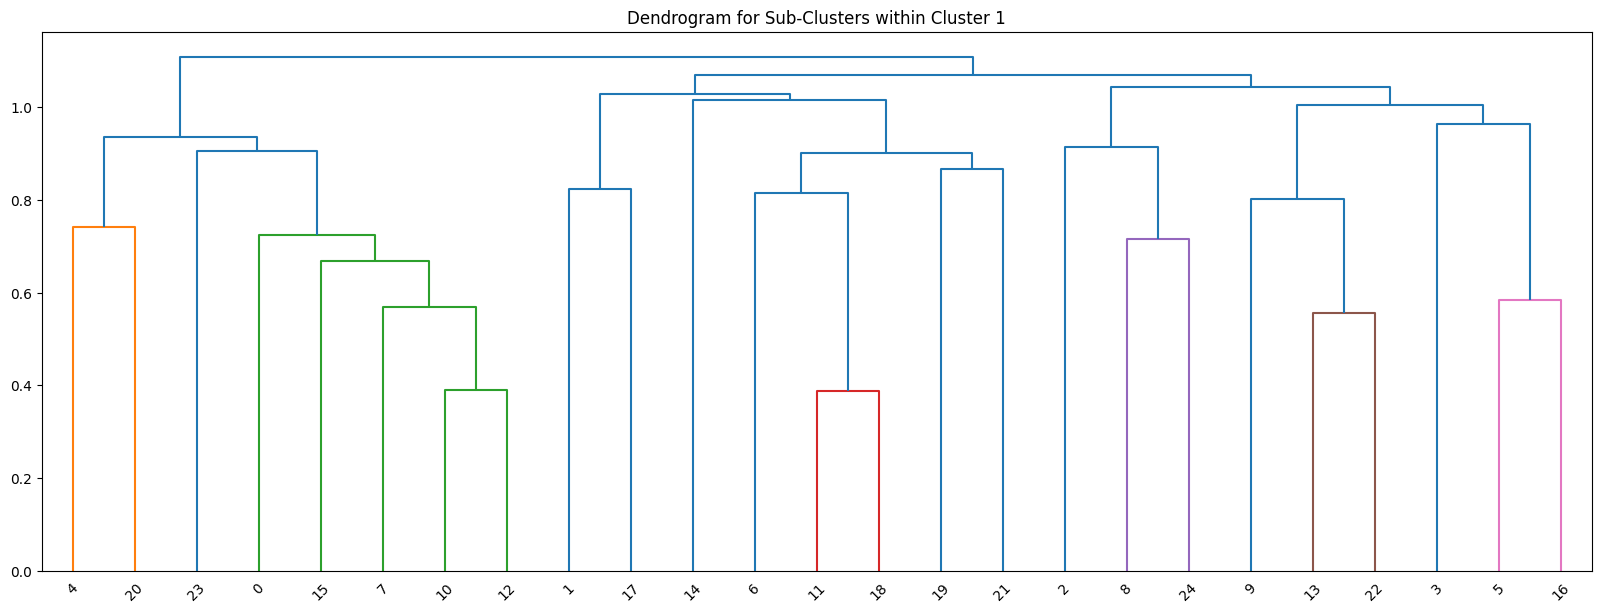

In [187]:
target_cluster = 1
target_data = df[df["Cluster_labels"] == target_cluster].reset_index()
subset_train_embeddings = scale_body_embeddings(target_data)

# Perform hierarchical clustering on the subset
Z_target = linkage(subset_train_embeddings, method='average', metric='cosine')

# Plot the dendrogram for the sub-cluster
plt.figure(figsize=(20, 7))
plt.title(f"Dendrogram for Sub-Clusters within Cluster {target_cluster}")
dendrogram(Z_target)
plt.show()

In [204]:
i = 0
dic = {}
max_d_range = np.arange(0.8, 1.2,0.02).tolist()
for d in max_d_range:
    clusters_train = fcluster(Z_target, d, criterion='distance')
    
    # Get unique elements and their counts
    unique_elements, counts = np.unique(clusters_train, return_counts=True)

    # Combine unique elements and counts into a dictionary for better readability
    cluster_counts = dict(zip(unique_elements, counts))  
    
    # Extract the counts (number of articles in each cluster)
    article_counts = np.array(list(cluster_counts.values()))

    # Calculate mean, median, and standard deviation
    mean_articles = np.mean(article_counts)
    stddev_articles = np.std(article_counts)

    # Specify the percentiles you want to calculate
    percentiles = [10, 25, 33, 65, 50, 70, 75, 80,81,82,83,84,85, 86,87,88,89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
    percentile_values = np.percentile(article_counts, percentiles)

    # Initialize the dictionary for the cluster
    dic[d] = {}
    dic[d]['num_clusters'] = len(article_counts)

    # Add mean, median, and standard deviation
    dic[d]['mean'] = round(mean_articles, 2)
    dic[d]['std'] = round(stddev_articles, 2)

    # Add the percentiles
    for i, percentile in enumerate(percentiles):
        dic[d][f'{percentile}th'] = round(percentile_values[i], 2)
    i += 1

# Convert the dictionary to a DataFrame
data = []

for d, stats in dic.items():
    for key, value in stats.items():
        if key in ['mean', 'std']:
            data.append({'max_d': d, 'statistic': key, 'value': value})
        elif key not in ['num_clusters']:
            percentile = int(key.replace('th', ''))
            data.append({'max_d': d, 'statistic': f'{percentile}', 'value': value})

# Create DataFrame with all values
distribution_df = pd.DataFrame(data)

# Pivot the DataFrame to have percentiles and other statistics as columns
pivot_df = distribution_df.pivot(index='max_d', columns='statistic', values='value')
pivot_df.reset_index(inplace=True)

# Rename the columns for better readability (optional)
pivot_df.columns.name = None
pivot_df.rename(columns={col: f'{col}' if isinstance(col, int) else col for col in pivot_df.columns}, inplace=True)

from tabulate import tabulate
print("Distribution for Body embeddings:")
print(tabulate(pivot_df, headers='keys', tablefmt='psql'))

Distribution for Body embeddings:
+----+---------+------+-------+-------+------+-------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------+
|    |   max_d |   10 |    25 |    33 |   50 |    65 |   70 |    75 |   80 |    81 |    82 |    83 |    84 |    85 |    86 |    87 |    88 |    89 |   90 |    91 |    92 |    93 |    94 |    95 |    96 |    97 |    98 |    99 |   mean |   std |
|----+---------+------+-------+-------+------+-------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------|
|  0 |    0.8  |  1   |  1    |  1    |  1   |  1.75 |  2   |  2    |  2   |  2    |  2    |  2    |  2    |  2    |  2    |  2    |  2    |  2    |  2   |  2    |  2    |  2    |  2.3  |  2.75 |  3.2  |  3.65 |  4.1  |  4.55 |   1

In [205]:
max_d = 1
distri_df = pivot_df[round(pivot_df["max_d"],2) == max_d].reset_index()
print(f"Distribution for Body embeddings at {max_d} max_d:")
print(tabulate(distri_df, headers='keys', tablefmt='psql'))

Distribution for Body embeddings at 1 max_d:
+----+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--------+-------+
|    |   index |   max_d |   10 |   25 |   33 |   50 |   65 |   70 |   75 |   80 |   81 |   82 |   83 |   84 |   85 |   86 |   87 |   88 |   89 |   90 |   91 |   92 |   93 |   94 |   95 |   96 |   97 |   98 |   99 |   mean |   std |
|----+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--------+-------|
|  0 |      10 |       1 |  1.6 |  2.5 | 2.98 |    3 |    3 |  3.4 |    4 |  4.6 | 4.72 | 4.84 | 4.96 | 5.12 |  5.3 | 5.48 | 5.66 | 5.84 | 6.02 |  6.2 | 6.38 | 6.56 | 6.74 | 6.92 |  7.1 | 7.28 | 7.46 | 7.64 | 7.82 |   3.57 |  2.13 |
+----+---------+-------

In [218]:
max_d = 0.92
distri_df = pivot_df[round(pivot_df["max_d"],2) == max_d].reset_index()
print(f"Distribution for Body embeddings at {max_d} max_d:")
print(tabulate(distri_df, headers='keys', tablefmt='psql'))

Distribution for Body embeddings at 0.92 max_d:
+----+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--------+-------+
|    |   index |   max_d |   10 |   25 |   33 |   50 |   65 |   70 |   75 |   80 |   81 |   82 |   83 |   84 |   85 |   86 |   87 |   88 |   89 |   90 |   91 |   92 |   93 |   94 |   95 |   96 |   97 |   98 |   99 |   mean |   std |
|----+---------+---------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--------+-------|
|  0 |       6 |    0.92 |    1 |    2 |    2 |    2 |    3 |    3 |    3 |  3.8 | 3.96 | 4.12 | 4.28 | 4.44 |  4.6 | 4.76 | 4.92 | 5.04 | 5.12 |  5.2 | 5.28 | 5.36 | 5.44 | 5.52 |  5.6 | 5.68 | 5.76 | 5.84 | 5.92 |   2.78 |  1.62 |
+----+---------+----

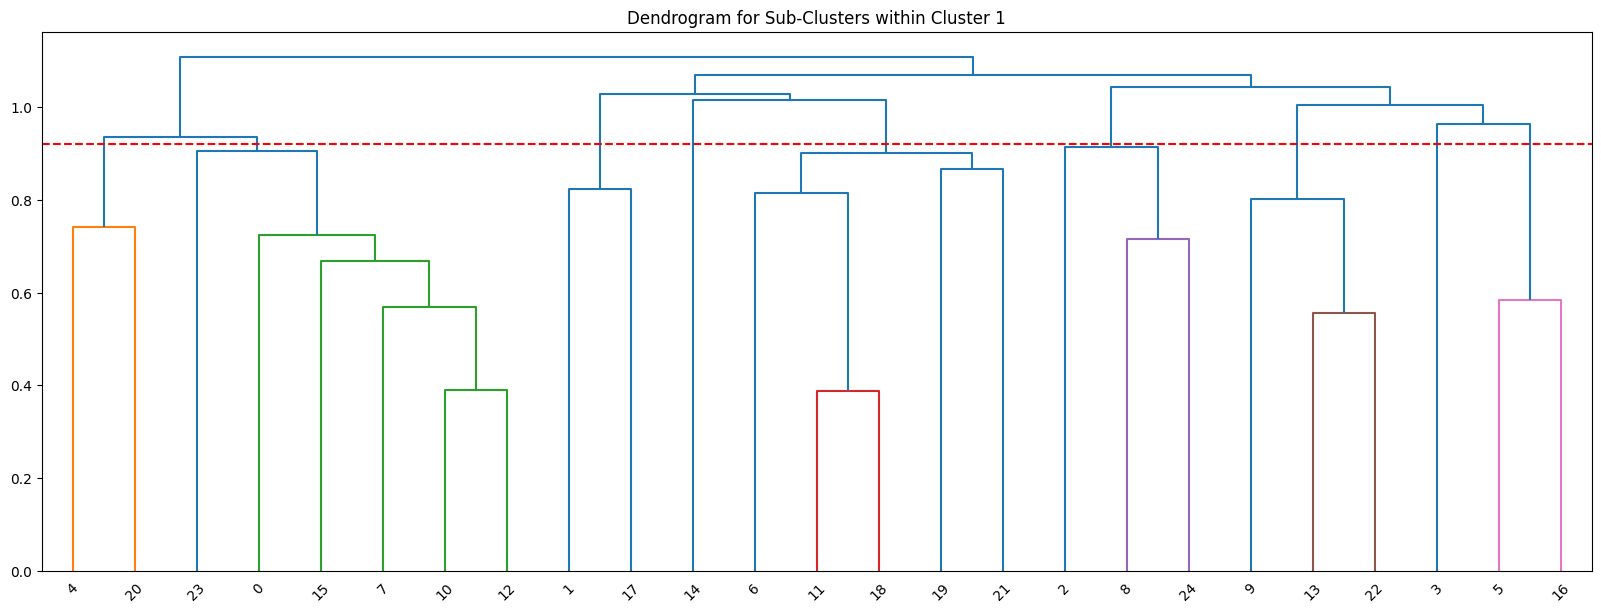

In [219]:
chosen_d = 0.92
# Plot the dendrogram for the sub-cluster
plt.figure(figsize=(20, 7))
plt.title(f"Dendrogram for Sub-Clusters within Cluster {target_cluster}")
dendrogram(Z_target)
plt.axhline(y=chosen_d, color='r', linestyle='--')
plt.show()

In [211]:
max_d = chosen_d
clusters_train = fcluster(Z_target, max_d, criterion='distance')
    
# Get unique elements and their counts
unique_elements, counts = np.unique(clusters_train, return_counts=True)

# Combine unique elements and counts into a dictionary for better readability
cluster_counts = dict(zip(unique_elements, counts))  
    
# Extract the counts (number of articles in each cluster)
article_counts = np.array(list(cluster_counts.values()))

labels = clusters_train.tolist()
target_data['Cluster_labels'] = labels

In [212]:
set(labels)

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [215]:
# WHat i want to find out is what the labels of each cluster are in each of these percentiles. 
def view_cluster(df, cluster_num):
    label = list(cluster_counts.keys())[cluster_num-1]
    print(f"Cluster {label}\n")
    print("-" * 80)
    s = ""
    count = 0
    for t in df[df['Cluster_labels'] == label]['Title'].values.tolist():
        s += f"- {t}\n" 
        print(f"- {t}\n")
        count += 1
    print(f"Number of articles: {count}")
    generated_label = groq_header(s)
    print(f"Generated label: {generated_label}\n")
    return generated_label

sub_cluster_labels = []
for i in range(len(set(labels))):
    sub_cluster_label = view_cluster(target_data, i)
    sub_cluster_labels.append(sub_cluster_label)

Cluster 9

--------------------------------------------------------------------------------
- ‘Godzilla had a kid’: Rogue monitor lizards interrupt Singapore Grand Prix practice session 

Number of articles: 1
Generated label: Unconventional Interruptions in Sports Events

Cluster 1

--------------------------------------------------------------------------------
- Team by team analysis of the Las Vegas Grand Prix

- Fuel system problem rules Sainz out of Qatar Grand Prix

Number of articles: 2
Generated label: Grand Prix Racing Issues

Cluster 2

--------------------------------------------------------------------------------
- Red Bull take constructors’ title as Max Verstappen wins in Japan

- Verstappen holds off Hamilton for 50th career F1 win

- Red Bull’s Max Verstappen fastest in US GP practice

- Albon flies as Verstappen completes Mexico practice sweep

- Perez to feel the love even if the dream is dashed

- McLaren can be a real threat to Red Bull next season, says Brawn

Nu

In [216]:
for i in range(len(sub_cluster_labels)):
    print(f"Sub-Cluster {i+1} label: " + sub_cluster_labels[i])

Sub-Cluster 1 label: Unconventional Interruptions in Sports Events
Sub-Cluster 2 label: Grand Prix Racing Issues
Sub-Cluster 3 label: Max Verstappen and Red Bull's F1 Dominance
Sub-Cluster 4 label: Formula One and FIA Developments
Sub-Cluster 5 label: Formula One and Motorsport News
Sub-Cluster 6 label: Formula One Format Changes
Sub-Cluster 7 label: Racing and Motorsports in Singapore
Sub-Cluster 8 label: Motor Racing Crashes and Injuries
Sub-Cluster 9 label: Formula 1 and Racing


## Scaling across different databases with newly generated clusterings: 
- ### What we could do would be to form some form of ideal ratio between the percentiles? 

In [230]:
ranges = np.array([6,7,7,8.02, 9,11, 13, 15, 26.02])
new_ranges = ranges/ranges[0]
new_ranges

array([1.        , 1.16666667, 1.16666667, 1.33666667, 1.5       ,
       1.83333333, 2.16666667, 2.5       , 4.33666667])